# Imports

In [1]:
!pip install open3d
import os
from pathlib import Path
import cv2
import copy
from functools import cached_property

import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl


from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.4
    Uninstalling widgetsnbextension-3.6.4:
      Successfully uninstalled widgetsnbextension-3.6.4
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 2.3.6
    Uninstalling Werkzeug-2.3.6:
      Successfully uninstalled Werkzeug-2.3.6
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9

In [2]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, -angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def scale_image(image, percent, maxwh):
    max_width = maxwh[1]
    max_height = maxwh[0]
    max_percent_width = max_width / image.shape[1] * 100
    max_percent_height = max_height / image.shape[0] * 100
    max_percent = 0
    if max_percent_width < max_percent_height:
        max_percent = max_percent_width
    else:
        max_percent = max_percent_height
    if percent > max_percent:
        percent = max_percent
    width = int(image.shape[1] * percent / 100)
    height = int(image.shape[0] * percent / 100)
    result = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)
    return result, percent


def invariantMatchTemplate(
    rgbimage,
    rgbtemplate,
    method,
    matched_thresh,
    rgbdiff_thresh,
    rot_range,
    rot_interval,
    scale_range,
    scale_interval,
    rm_redundant,
    minmax,
):
    """
    rgbimage: RGB image where the search is running.
    rgbtemplate: RGB searched template. It must be not greater than the source image and have the same data type.
    method: [String] Parameter specifying the comparison method
    matched_thresh: [Float] Setting threshold of matched results(0~1).
    rgbdiff_thresh: [Float] Setting threshold of average RGB difference between template and source image.
    rot_range: [Integer] Array of range of rotation angle in degrees. Example: [0,360]
    rot_interval: [Integer] Interval of traversing the range of rotation angle in degrees.
    scale_range: [Integer] Array of range of scaling in percentage. Example: [50,200]
    scale_interval: [Integer] Interval of traversing the range of scaling in percentage.
    rm_redundant: [Boolean] Option for removing redundant matched results based on the width and height of the template.
    minmax:[Boolean] Option for finding points with minimum/maximum value.

    Returns: List of satisfied matched points in format [[point.x, point.y], angle, scale].
    """
    image_maxwh = rgbimage.shape
    height, width, numchannel = rgbtemplate.shape
    all_points = []
    if minmax == False:
        for next_angle in range(rot_range[0], rot_range[1], rot_interval):
            for next_scale in range(scale_range[0], scale_range[1], scale_interval):
                scaled_template, actual_scale = scale_image(
                    rgbtemplate, next_scale, image_maxwh
                )
                if next_angle == 0:
                    rotated_template = scaled_template
                else:
                    rotated_template = rotate_image(scaled_template, next_angle)
                if method == "TM_CCOEFF":
                    matched_points = cv2.matchTemplate(
                        rgbimage, rotated_template, cv2.TM_CCOEFF
                    )
                    satisfied_points = np.where(matched_points >= matched_thresh)
                elif method == "TM_CCOEFF_NORMED":
                    matched_points = cv2.matchTemplate(
                        rgbimage, rotated_template, cv2.TM_CCOEFF_NORMED
                    )
                    satisfied_points = np.where(matched_points >= matched_thresh)
                elif method == "TM_CCORR":
                    matched_points = cv2.matchTemplate(
                        rgbimage, rotated_template, cv2.TM_CCORR
                    )
                    satisfied_points = np.where(matched_points >= matched_thresh)
                elif method == "TM_CCORR_NORMED":
                    matched_points = cv2.matchTemplate(
                        rgbimage, rotated_template, cv2.TM_CCORR_NORMED
                    )
                    satisfied_points = np.where(matched_points >= matched_thresh)
                elif method == "TM_SQDIFF":
                    matched_points = cv2.matchTemplate(
                        rgbimage, rotated_template, cv2.TM_SQDIFF
                    )
                    satisfied_points = np.where(matched_points <= matched_thresh)
                elif method == "TM_SQDIFF_NORMED":
                    matched_points = cv2.matchTemplate(
                        rgbimage, rotated_template, cv2.TM_SQDIFF_NORMED
                    )
                    satisfied_points = np.where(matched_points <= matched_thresh)
                else:
                    raise Exception(
                        "There's no such comparison method for template matching."
                    )
                # print("satisfied_points", len(satisfied_points))
                for pt in zip(*satisfied_points[::-1]):
                    all_points.append([pt, next_angle, actual_scale])
    else:
        for next_angle in range(rot_range[0], rot_range[1], rot_interval):
            for next_scale in range(scale_range[0], scale_range[1], scale_interval):
                scaled_template, actual_scale = scale_image(
                    rgbtemplate, next_scale, image_maxwh
                )
                if next_angle == 0:
                    rotated_template = scaled_template
                else:
                    rotated_template = rotate_image(scaled_template, next_angle)
                if method == "TM_CCOEFF":
                    matched_points = cv2.matchTemplate(
                        rgbimage, rotated_template, cv2.TM_CCOEFF
                    )

                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matched_points)
                    if max_val >= matched_thresh:
                        # print(len(matched_points))
                        all_points.append([max_loc, next_angle, actual_scale, max_val])
                elif method == "TM_CCOEFF_NORMED":
                    matched_points = cv2.matchTemplate(
                        rgbimage, rotated_template, cv2.TM_CCOEFF_NORMED
                    )
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matched_points)
                    if max_val >= matched_thresh:
                        all_points.append([max_loc, next_angle, actual_scale, max_val])
                elif method == "TM_CCORR":
                    matched_points = cv2.matchTemplate(
                        rgbimage, rotated_template, cv2.TM_CCORR
                    )
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matched_points)
                    if max_val >= matched_thresh:
                        all_points.append([max_loc, next_angle, actual_scale, max_val])
                elif method == "TM_CCORR_NORMED":
                    matched_points = cv2.matchTemplate(
                        rgbimage, rotated_template, cv2.TM_CCORR_NORMED
                    )
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matched_points)
                    if max_val >= matched_thresh:
                        all_points.append([max_loc, next_angle, actual_scale, max_val])
                elif method == "TM_SQDIFF":
                    matched_points = cv2.matchTemplate(
                        rgbimage, rotated_template, cv2.TM_SQDIFF
                    )
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matched_points)
                    if min_val <= matched_thresh:
                        all_points.append([min_loc, next_angle, actual_scale, min_val])
                elif method == "TM_SQDIFF_NORMED":
                    matched_points = cv2.matchTemplate(
                        rgbimage, rotated_template, cv2.TM_SQDIFF_NORMED
                    )
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matched_points)
                    if min_val <= matched_thresh:
                        all_points.append([min_loc, next_angle, actual_scale, min_val])
                else:
                    raise Exception(
                        "There's no such comparison method for template matching."
                    )
        if method == "TM_CCOEFF":
            all_points = sorted(all_points, key=lambda x: -x[3])
        elif method == "TM_CCOEFF_NORMED":
            all_points = sorted(all_points, key=lambda x: -x[3])
        elif method == "TM_CCORR":
            all_points = sorted(all_points, key=lambda x: -x[3])
        elif method == "TM_CCORR_NORMED":
            all_points = sorted(all_points, key=lambda x: -x[3])
        elif method == "TM_SQDIFF":
            all_points = sorted(all_points, key=lambda x: x[3])
        elif method == "TM_SQDIFF_NORMED":
            all_points = sorted(all_points, key=lambda x: x[3])
    if rm_redundant == True:
        lone_points_list = []
        visited_points_list = []
        for point_info in all_points:
            point = point_info[0]
            scale = point_info[2]
            all_visited_points_not_close = True
            if len(visited_points_list) != 0:
                for visited_point in visited_points_list:
                    if (abs(visited_point[0] - point[0]) < (width * scale / 100)) and (
                        abs(visited_point[1] - point[1]) < (height * scale / 100)
                    ):
                        all_visited_points_not_close = False
                if all_visited_points_not_close == True:
                    lone_points_list.append(point_info)
                    visited_points_list.append(point)
            else:
                lone_points_list.append(point_info)
                visited_points_list.append(point)
        points_list = lone_points_list
    else:
        points_list = all_points
    return points_list


def show_template_match(source, template, points_list):
    height, width, z = template.shape

    fig, ax = plt.subplots(1)
    ax.imshow(source)
    print(points_list)

    for i in points_list:
        print(i[3])

    centers_list = []
    for point_info in points_list[0:5]:
        print(point_info)
        point = point_info[0]
        print("Point:", point)
        angle = point_info[1]
        print("Corresponding angle:", angle)
        scale = point_info[2]
        print("Corresponding scale:", scale)
        centers_list.append([point, scale])
        plt.scatter(
            point[0] + (width / 2) * scale / 100,
            point[1] + (height / 2) * scale / 100,
            s=20,
            color="red",
        )
        plt.scatter(point[0], point[1], s=20, color="green")
        rectangle = patches.Rectangle(
            (point[0], point[1]),
            width * scale / 100,
            height * scale / 100,
            color="red",
            alpha=0.50,
            label="Matched box",
        )
        # box = patches.Rectangle(
        #     (point[0], point[1]),
        #     width * scale / 100,
        #     height * scale / 100,
        #     color="green",
        #     alpha=0.50,
        #     label="Bounding box",
        # )
        transform = (
            mpl.transforms.Affine2D().rotate_deg_around(
                point[0] + width / 2 * scale / 100,
                point[1] + height / 2 * scale / 100,
                angle,
            )
            + ax.transData
        )
        rectangle.set_transform(transform)
        ax.add_patch(rectangle)
        # ax.add_patch(box)
        plt.legend(handles=[
            rectangle,
            # box
        ])
        print()
    # plt.grid(True)
    plt.show()
    fig2, ax2 = plt.subplots(1)
    ax2.imshow(source)
    for point_info in centers_list:
        point = point_info[0]
        scale = point_info[1]
        plt.scatter(
            point[0] + width / 2 * scale / 100,
            point[1] + height / 2 * scale / 100,
            s=20,
            color="red",
        )
    plt.show()


def show_result(source, template, scale, h, w, r, name_=None, offset=False):
    """
    scale = 10 means 10%
    """
    image_s = copy.deepcopy(source)
    image_t = copy.deepcopy(template)

    new_width = int(image_t.shape[1] * scale / 100)
    new_height = int(image_t.shape[0] * scale / 100)

    image_t = cv2.resize(image_t, (new_width, new_height))

    if len(image_s.shape) != 2:
        image_s = cv2.cvtColor(image_s, cv2.COLOR_BGR2GRAY)

    if len(image_t.shape) != 2:
        image_t = cv2.cvtColor(image_t, cv2.COLOR_BGR2GRAY)

    from scipy.ndimage import rotate as rotate_image
    import math
    image_t_ = rotate_image(image_t, r)

    # plt.imshow(image_t_)
    # plt.show()

    canvas = np.zeros((image_s.shape[0] + image_t_.shape[0], image_s.shape[1] + image_t_.shape[1]), dtype=np.uint8)
    canvas[:image_s.shape[0], :image_s.shape[1]] = image_s[:, :]

    alpha = 0.7

    r_radians = math.radians(r)
    # print(0, h, w)
    t_w_0 = int(math.sin(r_radians) * image_t_.shape[0])
    t_w_1 = int(math.sin(r_radians) * image_t_.shape[1])

    t_w_0 = int(math.cos(r_radians) * image_t_.shape[0])
    t_h_1 = int(math.cos(r_radians) * image_t_.shape[1])
    # h -= t_h
    if offset:
        w -= t_w_1 // 2
    # print(1, h, w)
    print(t_w_0, t_w_1, t_w_0, t_h_1)

    canvas[
        h :image_t_.shape[0]+ h,
        w :image_t_.shape[1]+ w
    ] = canvas[h:image_t_.shape[0]+h, w:image_t_.shape[1]+w] + alpha  * image_t_[:, :]

    plt.imshow(canvas[:image_s.shape[0], :image_s.shape[1]])
    plt.show()
    if name_:
        cv2.imwrite(name_, canvas[:image_s.shape[0], :image_s.shape[1]])


In [3]:
def show_range_coords(ply):
    ply_np = np.asarray(ply.points)
    print()
    for i in range(3):
        print(
            ply_np[:, i].min(),
            ply_np[:, i].max(),
            "range:",
            ply_np[:, i].max() - ply_np[:, i].min()
        )


def radius(ply):
    distances = ply.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    return avg_dist


def normalize_ply(ply_source, ply_template):
    print(radius(ply_source))
    print(radius(ply_template))

    # scale = 1 / (radius(ply_template))
    # print("scaling", scale)
    # # scale = 1

    show_range_coords(ply_source)
    show_range_coords(ply_template)

    ply_source_np = np.asarray(ply_source.points)
    ply_template_np = np.asarray(ply_template.points)

    s_range = ply_source_np[:, 0].max() - ply_source_np[:, 0].min()
    t_range = ply_template_np[:, 0].max() - ply_template_np[:, 0].min()
    scale_ = s_range / t_range
    print("scale_f:", scale_)
    ply_template.scale(scale_, center=ply_template.get_center())


def generate_input(ply_np, interval=1, dilate=None):
    z = (
        int((ply_np[:, 0].max() - ply_np[:, 0].min())/interval),
        int((ply_np[:, 1].max() - ply_np[:, 1].min())/interval),
    )
    print(z)
    image = np.zeros(z)
    points_around_x_min = int(ply_np[:, 0].min())
    points_around_y_min = int(ply_np[:, 1].min())

    mapping = {}

    for ind_, point_around in enumerate(ply_np):
        image[
            int((point_around[0] - (points_around_x_min + 2))/interval),
            int((point_around[1] - (points_around_y_min + 2))/interval)
        ] = 255

        mapping[(
            int((point_around[0] - (points_around_x_min + 2))/interval),
            int((point_around[1] - (points_around_y_min + 2))/interval)
        )] = ind_

    cv_image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    if dilate:
        kernel = np.ones((dilate, dilate), np.uint8)
        cv_image = cv2.dilate(cv_image, kernel, iterations=1)

    # cv_image = cv2.resize(cv_image, (20, 20))
    image = np.array(cv_image)

    plt.imshow(image)
    plt.show()
    return cv_image, mapping


def get_path(test_case, level="easy", t_name=None, s_name=None):
    base_path = "/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/ply_reg/"
    base_path = Path(base_path)
    source_path = base_path / test_case / f"color_pd30_8bit_{level}_sliced.ply"
    template_path = base_path / test_case / f"fused_ele_aligned_sliced.ply"
    return str(template_path), str(source_path)

# Template Matching Test

(131, 160, 3)


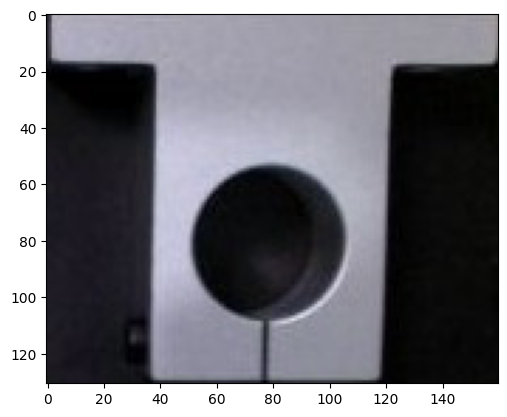

Point: (331, 75)
Corresponding angle: 0
Corresponding scale: 100

Point: (133, 90)
Corresponding angle: 240
Corresponding scale: 100



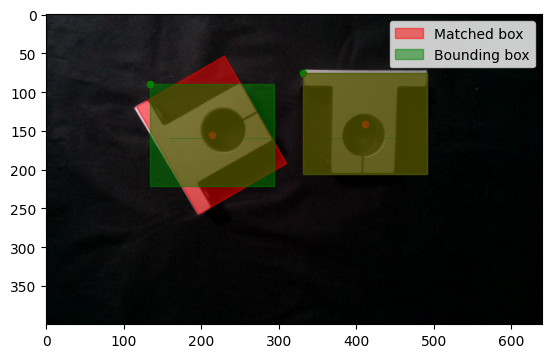

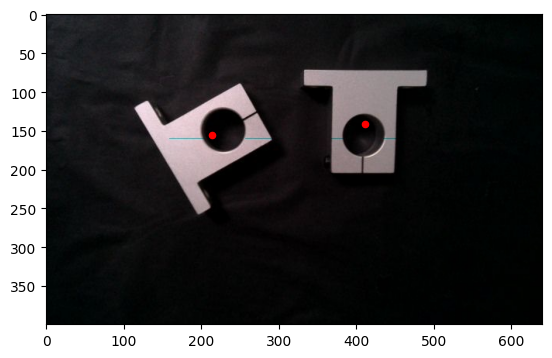

In [ ]:
img_bgr = cv2.imread("/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/image_1.png")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

template_bgr = plt.imread("/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/template_1.jpg")
template_rgb = cv2.cvtColor(template_bgr, cv2.COLOR_BGR2RGB)
print(template_rgb.shape)
height, width, z = template_rgb.shape

plt.imshow(template_rgb)
plt.show()

points_list = invariantMatchTemplate(
    img_rgb,
    template_rgb,
    "TM_CCOEFF_NORMED",
    0.5,
    500,
    [0, 360],
    10,
    [100, 150],
    10,
    True,
    True,
)
fig, ax = plt.subplots(1)
ax.imshow(img_rgb)
centers_list = []
for point_info in points_list:
    point = point_info[0]
    print("Point:", point)
    angle = point_info[1]
    print("Corresponding angle:", angle)
    scale = point_info[2]
    print("Corresponding scale:", scale)
    centers_list.append([point, scale])
    plt.scatter(
        point[0] + (width / 2) * scale / 100,
        point[1] + (height / 2) * scale / 100,
        s=20,
        color="red",
    )
    plt.scatter(point[0], point[1], s=20, color="green")
    rectangle = patches.Rectangle(
        (point[0], point[1]),
        width * scale / 100,
        height * scale / 100,
        color="red",
        alpha=0.50,
        label="Matched box",
    )
    box = patches.Rectangle(
        (point[0], point[1]),
        width * scale / 100,
        height * scale / 100,
        color="green",
        alpha=0.50,
        label="Bounding box",
    )
    transform = (
        mpl.transforms.Affine2D().rotate_deg_around(
            point[0] + width / 2 * scale / 100,
            point[1] + height / 2 * scale / 100,
            angle,
        )
        + ax.transData
    )
    rectangle.set_transform(transform)
    ax.add_patch(rectangle)
    ax.add_patch(box)
    plt.legend(handles=[rectangle, box])
    print()
# plt.grid(True)
plt.show()
fig2, ax2 = plt.subplots(1)
ax2.imshow(img_rgb)
for point_info in centers_list:
    point = point_info[0]
    scale = point_info[1]
    plt.scatter(
        point[0] + width / 2 * scale / 100,
        point[1] + height / 2 * scale / 100,
        s=20,
        color="red",
    )
plt.show()


# dataset

0.8510539424097731
0.01897037009705568

724708.61 724808.58 range: 99.96999999997206
5031841.61 5031941.59 range: 99.97999999951571
56.01 61.61 range: 5.600000000000001

-3.9341232776641846 3.2819178104400635 range: 7.216041088104248
-3.2633066177368164 4.414106369018555 range: 7.677412986755371
-0.49035441875457764 1.6505919694900513 range: 2.140946388244629
scale_f: 13.853856814198869
(333, 333)


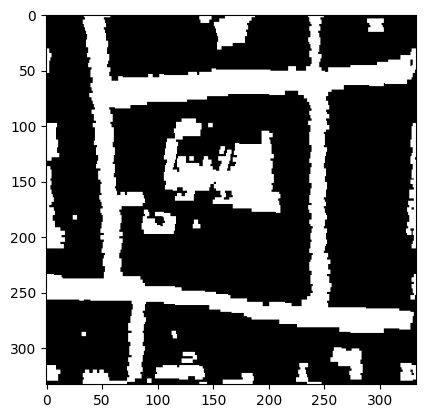

(333, 354)


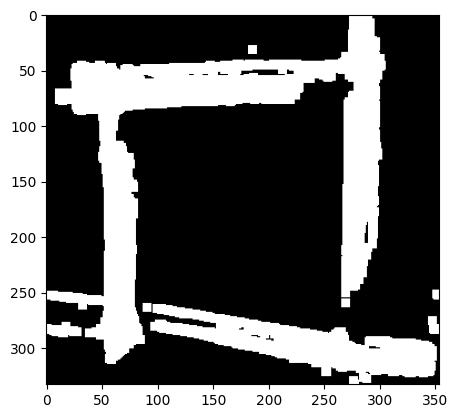

0.7919594150144615
0.01897037009705568

724658.61 724858.59 range: 199.97999999998137
5031791.61 5031991.58 range: 199.96999999973923
55.55 62.68 range: 7.130000000000003

-3.9341232776641846 3.2819178104400635 range: 7.216041088104248
-3.2633066177368164 4.414106369018555 range: 7.677412986755371
-0.49035441875457764 1.6505919694900513 range: 2.140946388244629
scale_f: 27.713256834090288
(666, 666)


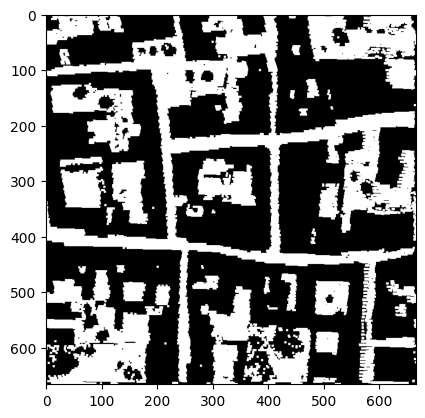

(666, 709)


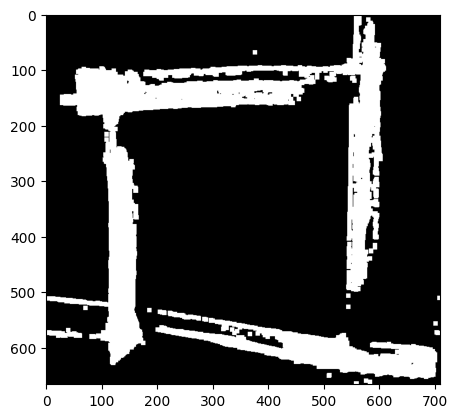

0.7385908641177452
0.01897037009705568

724608.61 724908.59 range: 299.9799999999814
5031741.61 5032041.58 range: 299.96999999973923
54.83 62.98 range: 8.149999999999999

-3.9341232776641846 3.2819178104400635 range: 7.216041088104248
-3.2633066177368164 4.414106369018555 range: 7.677412986755371
-0.49035441875457764 1.6505919694900513 range: 2.140946388244629
scale_f: 41.57127105255857
(999, 999)


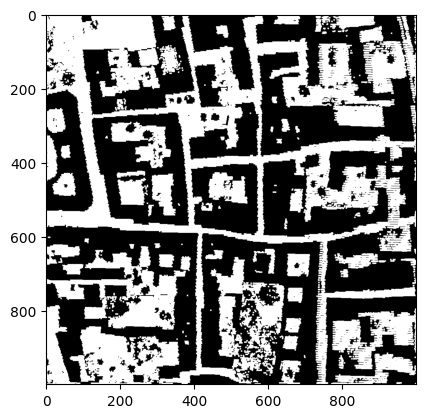

(999, 1063)


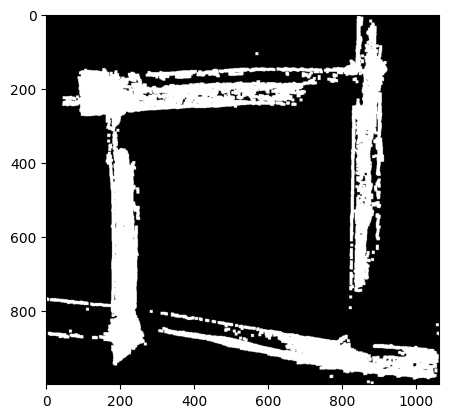

In [4]:
def get_source_template(ply_path_template, ply_path):
    ply = o3d.io.read_point_cloud(ply_path)
    ply_template = o3d.io.read_point_cloud(ply_path_template)

    normalize_ply(ply, ply_template)

    # ply = preprocess_ply(ply)
    # ply_template = preprocess_ply(ply_template, scale=11.23)

    ply_np = np.asarray(ply.points)
    ply_template_np = np.asarray(ply_template.points)

    source, mapping_source = generate_input(ply_np, 0.3, 4)
    template, mapping_template  = generate_input(ply_template_np, 0.3, 8)  # 0.5
    return source, template, ply, ply_template, mapping_source, mapping_template


# 4_3_3
# ply_path =          "/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/ply_reg/color_pd30_8bit_small_street_4_3_3_ele_uniformed_sliced.ply"
# ply_path_template = "/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/ply_reg/fused_uniformed_aligned_rotated.ply"

# ply_path_template, ply_path = get_path("4_0_1", "hard")
# ply_path_template, ply_path = get_path("4_1_3", "easy")
# ply_path_template, ply_path = get_path("4_3_2", "easy")
# ply_path_template, ply_path = get_path("4_3_3", "medium")

# ply_path_template, ply_path = get_path("5_1_2", "hard")
# ply_path_template, ply_path = get_path("5_2_1", "easy")
# ply_path_template, ply_path = get_path("5_2_3", "easy")
# ply_path_template, ply_path = get_path("5_2_4", "easy")
# ply_path_template, ply_path = get_path("5_3_1", "easy")
# ply_path_template, ply_path = get_path("5_6_1", "easy")
# ply_path_template, ply_path = get_path("5_6_2", "easy")

# source, template = get_source_template(ply_path_template, ply_path)
cases = [
    # "4_0_1",
    # "4_1_3",
    # "4_3_2",
    "4_3_3",
    # "5_1_2",
    # "5_2_1",
    # "5_2_3",
    # "5_2_4",
    # "5_3_1",
    # "5_6_1",
    # "5_6_2",
    # "5_7_1",
    # "5_7_2"
]

sources = []
templates = []
ply_sources = []
ply_templates = []
plys = []

names = []
for c in cases:
    for level in ("easy", "medium", "hard"):
        ply_path_template, ply_path = get_path(c, level)
        source, template, ply_source, ply_template, mapping_source, mapping_template = get_source_template(ply_path_template, ply_path)
        plys.append(
            (ply_source, ply_template, mapping_source, mapping_template)
        )
        sources.append(source)
        templates.append(template)

        names.append(f"{c}_{level}.png")


# Template Matching

In [ ]:
points_list = invariantMatchTemplate(
    source,
    template,
    "TM_CCORR",
    0.99,
    500,
    [0, 360],
    10,
    [10, 200],
    10,
    True,
    True,
)

[[(525, 0), 10, 33.69565217391305, 8767775744.0], [(16, 78), 290, 20, 2718545408.0], [(1072, 455), 350, 10, 1339631360.0], [(834, 623), 190, 10, 1320360960.0], [(1100, 57), 240, 10, 902286912.0]]
8767775744.0
2718545408.0
1339631360.0
1320360960.0
902286912.0
[(525, 0), 10, 33.69565217391305, 8767775744.0] 4
Point: (525, 0)
Corresponding angle: 10
Corresponding scale: 33.69565217391305

[(16, 78), 290, 20, 2718545408.0] 4
Point: (16, 78)
Corresponding angle: 290
Corresponding scale: 20

[(1072, 455), 350, 10, 1339631360.0] 4
Point: (1072, 455)
Corresponding angle: 350
Corresponding scale: 10

[(834, 623), 190, 10, 1320360960.0] 4
Point: (834, 623)
Corresponding angle: 190
Corresponding scale: 10

[(1100, 57), 240, 10, 902286912.0] 4
Point: (1100, 57)
Corresponding angle: 240
Corresponding scale: 10



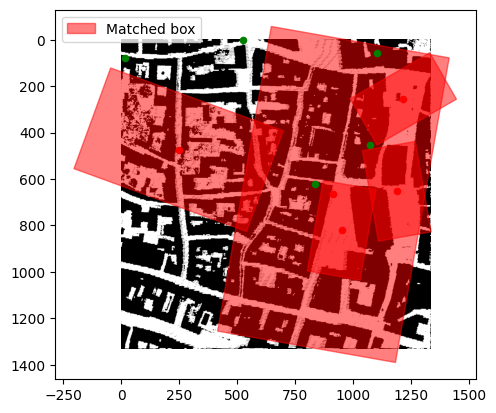

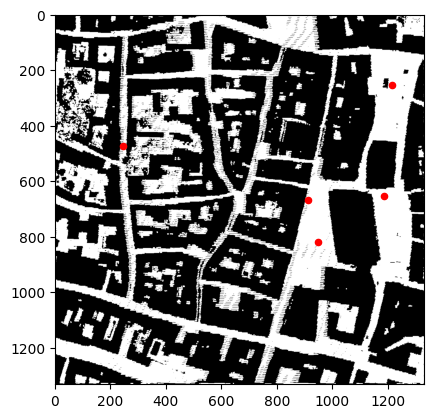

In [ ]:
height, width, z = template.shape

fig, ax = plt.subplots(1)
ax.imshow(source)
print(points_list)

for i in points_list:
    print(i[3])

centers_list = []
for point_info in points_list[0:5]:
    print(point_info, len(point_info))
    point = point_info[0]
    print("Point:", point)
    angle = point_info[1]
    print("Corresponding angle:", angle)
    scale = point_info[2]
    print("Corresponding scale:", scale)
    centers_list.append([point, scale])
    plt.scatter(
        point[0] + (width / 2) * scale / 100,
        point[1] + (height / 2) * scale / 100,
        s=20,
        color="red",
    )
    plt.scatter(point[0], point[1], s=20, color="green")
    rectangle = patches.Rectangle(
        (point[0], point[1]),
        width * scale / 100,
        height * scale / 100,
        color="red",
        alpha=0.50,
        label="Matched box",
    )
    # box = patches.Rectangle(
    #     (point[0], point[1]),
    #     width * scale / 100,
    #     height * scale / 100,
    #     color="green",
    #     alpha=0.50,
    #     label="Bounding box",
    # )
    transform = (
        mpl.transforms.Affine2D().rotate_deg_around(
            point[0] + width / 2 * scale / 100,
            point[1] + height / 2 * scale / 100,
            angle,
        )
        + ax.transData
    )
    rectangle.set_transform(transform)
    ax.add_patch(rectangle)
    # ax.add_patch(box)
    plt.legend(handles=[
        rectangle,
        # box
    ])
    print()
# plt.grid(True)
plt.show()
fig2, ax2 = plt.subplots(1)
ax2.imshow(source)
for point_info in centers_list:
    point = point_info[0]
    scale = point_info[1]
    plt.scatter(
        point[0] + width / 2 * scale / 100,
        point[1] + height / 2 * scale / 100,
        s=20,
        color="red",
    )
plt.show()

scale: 33.69565217391305 angle 10 (525, 0)
1426 -173 1426 982


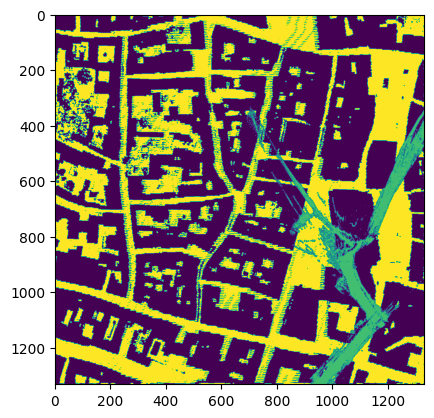

In [ ]:
result = points_list[0]
w, h = result[0]
angle = result[1]
scale = result[2]
print("scale:", scale, "angle", angle, result[0])

show_result(source, template, scale, h, w, -angle)

# Bulk run

scale: 90 angle 0 (0, 2)
[[(0, 2), 0, 90, 2725411584.0], [(128, 156), 190, 40, 580472192.0], [(160, 49), 90, 30, 380622720.0], [(168, 131), 0, 10, 61234428.0]]
2725411584.0
580472192.0
380622720.0
61234428.0
[(0, 2), 0, 90, 2725411584.0]
Point: (0, 2)
Corresponding angle: 0
Corresponding scale: 90

[(128, 156), 190, 40, 580472192.0]
Point: (128, 156)
Corresponding angle: 190
Corresponding scale: 40

[(160, 49), 90, 30, 380622720.0]
Point: (160, 49)
Corresponding angle: 90
Corresponding scale: 30

[(168, 131), 0, 10, 61234428.0]
Point: (168, 131)
Corresponding angle: 0
Corresponding scale: 10



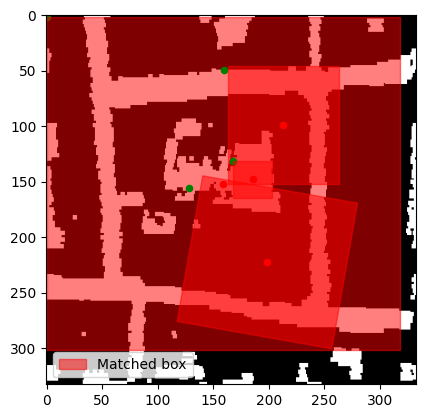

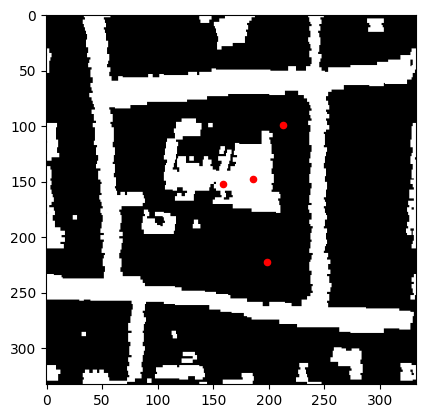

299 0 299 318


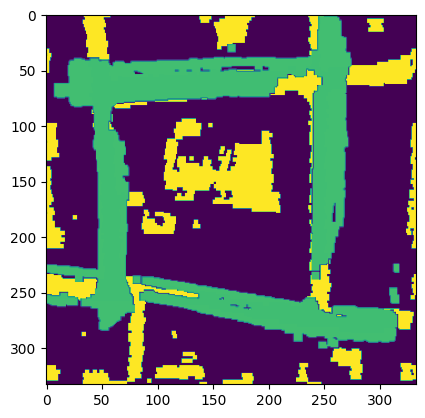

scale: 93.93511988716502 angle 270 (0, 4)
[[(0, 4), 270, 93.93511988716502, 8094076416.0], [(291, 3), 80, 40, 1908345088.0], [(14, 383), 180, 40, 1857441280.0], [(298, 397), 310, 40, 1400972800.0], [(44, 524), 180, 20, 612391680.0], [(517, 239), 280, 20, 579782080.0], [(200, 216), 80, 20, 573390464.0], [(189, 83), 180, 10, 183056112.0], [(82, 595), 280, 10, 177448640.0]]
8094076416.0
1908345088.0
1857441280.0
1400972800.0
612391680.0
579782080.0
573390464.0
183056112.0
177448640.0
[(0, 4), 270, 93.93511988716502, 8094076416.0]
Point: (0, 4)
Corresponding angle: 270
Corresponding scale: 93.93511988716502

[(291, 3), 80, 40, 1908345088.0]
Point: (291, 3)
Corresponding angle: 80
Corresponding scale: 40

[(14, 383), 180, 40, 1857441280.0]
Point: (14, 383)
Corresponding angle: 180
Corresponding scale: 40

[(298, 397), 310, 40, 1400972800.0]
Point: (298, 397)
Corresponding angle: 310
Corresponding scale: 40

[(44, 524), 180, 20, 612391680.0]
Point: (44, 524)
Corresponding angle: 180
Correspo

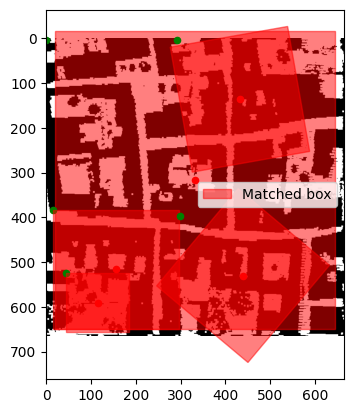

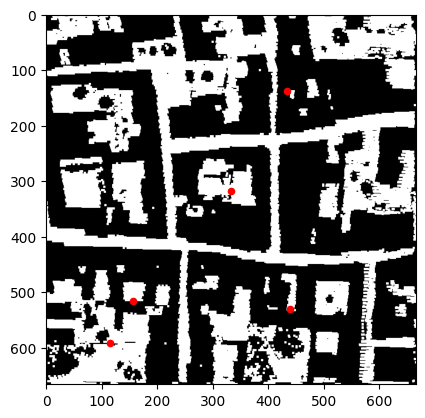

0 625 0 0
0 625 0 0


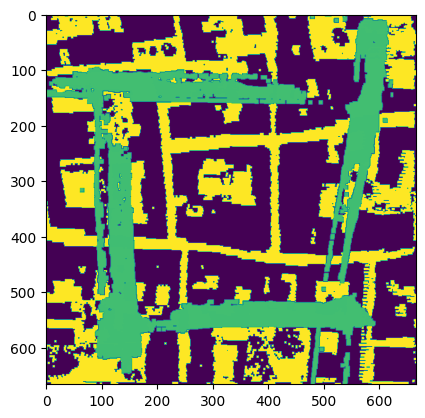

scale: 93.97930385700846 angle 180 (0, 33)
[[(0, 33), 180, 93.97930385700846, 15748979712.0], [(0, 499), 100, 40, 3473880064.0], [(457, 122), 130, 40, 2941994240.0], [(745, 70), 210, 20, 1077331200.0], [(153, 781), 300, 20, 1075402752.0], [(180, 0), 180, 10, 353013888.0]]
15748979712.0
3473880064.0
2941994240.0
1077331200.0
1075402752.0
353013888.0
[(0, 33), 180, 93.97930385700846, 15748979712.0]
Point: (0, 33)
Corresponding angle: 180
Corresponding scale: 93.97930385700846

[(0, 499), 100, 40, 3473880064.0]
Point: (0, 499)
Corresponding angle: 100
Corresponding scale: 40

[(457, 122), 130, 40, 2941994240.0]
Point: (457, 122)
Corresponding angle: 130
Corresponding scale: 40

[(745, 70), 210, 20, 1077331200.0]
Point: (745, 70)
Corresponding angle: 210
Corresponding scale: 20

[(153, 781), 300, 20, 1075402752.0]
Point: (153, 781)
Corresponding angle: 300
Corresponding scale: 20



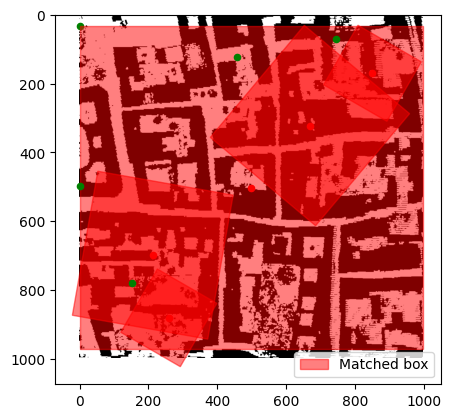

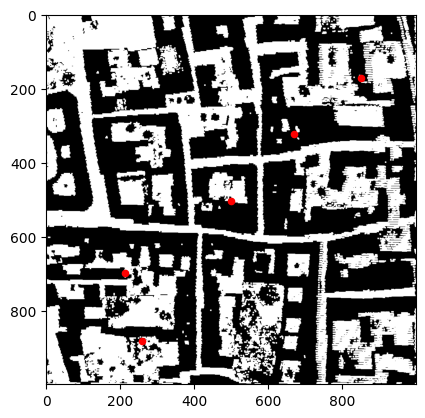

-938 0 -938 -999


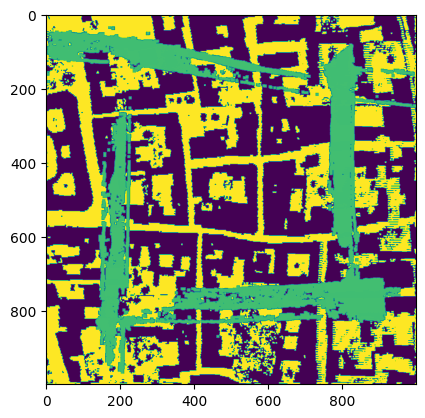

In [5]:
results = []

for source, template, name_ in zip(sources, templates, names):
    height, width, z = template.shape

    points_list = invariantMatchTemplate(
        source,
        template,
        "TM_CCORR",
        # "TM_CCOEFF",
        # "TM_SQDIFF",
        0.9,
        500,
        [0, 360],
        10,
        [10, 200],
        10,
        True,
        True,
    )
    results.append(points_list)
    result = points_list[0]
    w, h = result[0]
    angle = result[1]
    scale = result[2]
    print("scale:", scale, "angle", angle, result[0])

    show_template_match(source, template, points_list)

    # show_result(source, template, scale, h, w, -angle, name_)
    try:
        show_result(
            source=source,
            template=template,
            scale=scale,
            h=h,
            w=w,
            r=-angle,
            name_=None,
            offset=True
        )
    except Exception as e:
        show_result(
            source=source,
            template=template,
            scale=scale,
            h=h,
            w=w,
            r=-angle,
            name_=None,
            offset=False
        )


# ICP Refinement

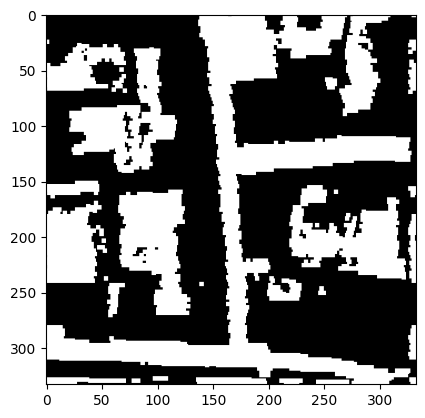

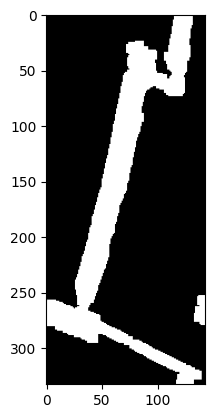


724690.0 724789.97 range: 99.96999999997206
5031807.03 5031906.94 range: 99.91000000014901
55.55 61.75 range: 6.200000000000003

-40.56387603430568 59.40612396566639 range: 99.96999999997206
-24.300593478687944 18.63663274546052 range: 42.93722622414846
-0.8856617299024763 1.6027938166064915 range: 2.488455546508968


In [ ]:
ind_ = 0


source_, template_,  = sources[ind_], templates[ind_]
ply_source_, ply_template_, mapping_source, mapping_template = plys[ind_]
plt.imshow(source_)
plt.show()
plt.imshow(template_)
plt.show()


show_range_coords(ply_source_)
show_range_coords(ply_template_)


In [ ]:
def get_transformation(source_, template_, result, resolution):
    print(result)

    point = result[0]
    angle = 360 - result[1]
    scale = result[2] / 100

    point = (390, 390)
    point = (250, -20)
    angle = 110
    scale = 20 / 100



    print("scale:", scale)
    source = copy.deepcopy(source_)
    template = copy.deepcopy(template_)

    show_range_coords(source)
    show_range_coords(template)



    source_ply_np = np.asarray(source.points)
    template_ply_np = np.asarray(template.points)

    x_min, y_min, z_min = source_ply_np[:, 0].min(), source_ply_np[:, 1].min(), source_ply_np[:, 2].min()
    x_min_t, y_min_t, z_min_t = template_ply_np[:, 0].min(), template_ply_np[:, 1].min(), template_ply_np[:, 2].min()
    x_max_t, y_max_t, z_max_t = template_ply_np[:, 0].max(), template_ply_np[:, 1].max(), template_ply_np[:, 2].max()

    template.translate([
        x_min + (x_max_t - x_min_t)/2,
        y_min + (y_max_t - y_min_t)/2,
        z_min + (z_max_t - z_min_t)/2
        ],
        relative=False
    )

    template.scale(scale, center=template.get_center())

    import math


    R = template.get_rotation_matrix_from_xyz((0, 0, math.radians(angle)))
    template.rotate(
        R,
        center=
        # (template_ply_np[:, 0].min(), template_ply_np[:, 1].min(), template_ply_np[:, 2].min())
                    template.get_center()
                    )

    template.translate([
            point[1]/resolution,
            point[0]/resolution,
            0
        ],
        relative=True
    )



    source.paint_uniform_color([0, 1, 0])
    template.paint_uniform_color([0, 0, 1])

    pcd_combined = o3d.geometry.PointCloud()
    pcd_combined = source + template
    pcd_combined.colors = o3d.utility.Vector3dVector(
        np.concatenate(
            [np.asarray(source.colors), np.asarray(template.colors)],
        )
    )
    o3d.io.write_point_cloud("ply_combined_before.ply", pcd_combined)

    threshold = 1
    transformation_1 = np.asarray([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    print("Apply point-to-point ICP")
    reg_p2p = o3d.pipelines.registration.registration_icp(
        template,
        source,
        threshold,
        transformation_1,
        o3d.pipelines.registration.TransformationEstimationPointToPoint()
    )
    print(reg_p2p)
    print("Transformation is:")
    print(reg_p2p.transformation)
    print("")

    template.transform(reg_p2p.transformation)

    pcd_combined = o3d.geometry.PointCloud()
    pcd_combined = source + template
    pcd_combined.colors = o3d.utility.Vector3dVector(
        np.concatenate(
            [np.asarray(source.colors), np.asarray(template.colors)],
        )
    )
    o3d.io.write_point_cloud("ply_combined_after.ply", pcd_combined)



ind_ = 2

source_, template_,  = sources[ind_], templates[ind_]
ply_source_, ply_template_, mapping_source, mapping_template = plys[ind_]

res_ = results[ind_][0]  # case, attempt
get_transformation(ply_source_, ply_template_, res_, 3.333)

[(16, 0), 200, 100, 9816006656.0]
scale: 0.2

724818.875 725118.8125 range: 299.9375
5031941.0 5032241.0 range: 300.0
52.58000183105469 63.83000183105469 range: 11.25

-149.5474104598121 150.3900895401879 range: 299.9375
-117.32456868324232 49.48750047924755 range: 166.81206916248988
-28.8499226822195 21.703164912438673 range: 50.55308759465817
Apply point-to-point ICP
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
Transformation is:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

